**Project Planning:**

1. Load my data and check how it looks like (Exploratory Data Analysis EDA)
2. Tokenize and clean the data from: html marks, useless words
3. Split my data between training and test sets (maybe cross-validation as well?)
4. Transform the text into numeric data so my neural network can work with it.
5. Visualize the transformed data and check if it is as expected
6. Define my neural network architecture (detail planning for this step below)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical


# Step 1: Loading the Data & EDA


In [2]:
#IMDb Movie Reviews Dataset
data = pd.read_csv('IMDB Dataset.csv')

In [3]:
print("[Data Preview]\n",data.head())
print("\n[Count]\n",data['sentiment'].value_counts(),"\n")
print(data.info())

[Data Preview]
                                               review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

[Count]
 sentiment
positive    25000
negative    25000
Name: count, dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


In [4]:
# Most frequent words in positive reviews
positive_words = ' '.join(data[data['sentiment'] == 'positive']['review']).split()
positive_word_freq = Counter(positive_words).most_common(10)

# Most frequent words in negative reviews
negative_words = ' '.join(data[data['sentiment'] == 'negative']['review']).split()
negative_word_freq = Counter(negative_words).most_common(10)

print('Top 10 Words in Positive Reviews:', positive_word_freq),
print('Top 10 Words in Negative Reviews:', negative_word_freq)

Top 10 Words in Positive Reviews: [('the', 291927), ('and', 165943), ('a', 155775), ('of', 149178), ('to', 128343), ('is', 108168), ('in', 90427), ('that', 62449), ('I', 62223), ('it', 53378)]
Top 10 Words in Negative Reviews: [('the', 276808), ('a', 151185), ('and', 135976), ('of', 134447), ('to', 133507), ('is', 94888), ('in', 79554), ('I', 70275), ('that', 64369), ('this', 62112)]


# Step 2: Pre-processing the Data
Tokenize and remove all html symbols and stopwords - neutral words that are not relevant to interprete the meaning of the sentences like the, to, and, it.
  

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup

# Download necessary NLTK resources
nltk.download('stopwords') # Stopwords list
nltk.download('punkt') # Tokenizer models
nltk.download('punkt_tab')

# Load stopwords
stop_words = set(stopwords.words('english')) - {'not', 'never'}

# Remove neutral words that appear often in both reviews
neutral_words = {} #{'movie', 'film', 'one', 'time', 'story', 'would', 'see', 'even', 'really'}

# Preprocessing pipeline
def preprocess_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # Tokenize, remove non-alphabetic words, convert to lowercase, and filter out stopwords and neutral words
    tokens = word_tokenize(text)
    filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words and word.lower() not in neutral_words]
    return ' '.join(filtered_tokens)

# Apply preprocessing to the dataset
data['cleaned_text'] = data['review'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
<ipython-input-5-e81b3112ebfc>:20: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


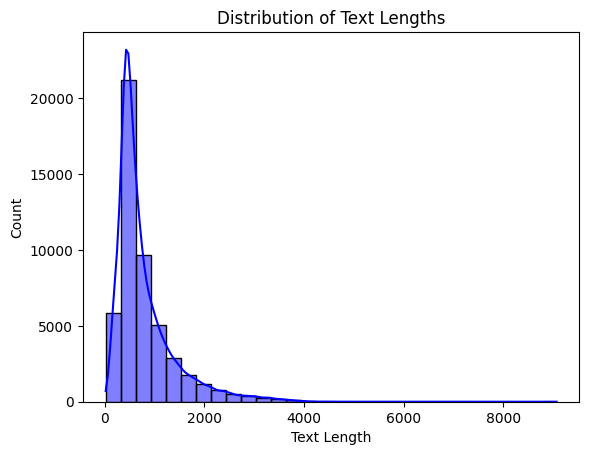

In [6]:
data['text_length'] = data['cleaned_text'].apply(len)

sns.histplot(data['text_length'], kde=True, bins=30, color='blue')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()


# Step 3: Splitting data into train / test sets
The data will be split before vectorizing it as this prevents data leakage, i.e. preventing the model from access information from the test set during training, which could lead to misleadingly high performance metrics.

In [7]:
# Split dataset into training and dataset
x = data['cleaned_text']
y = data['sentiment']

X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(x, y, test_size=0.2, random_state=42)

# one-hot-encoded y:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_text)
y_test_encoded = le.transform(y_test_text)

# Step 4: TF-IDF

In [8]:
# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit vocabulary size (adjust as needed)
    ngram_range=(1, 2,),  # Use unigrams and bigrams
    stop_words='english',
)

# Transform the text data into TF-IDF feature matrices
X_train = tfidf_vectorizer.fit_transform(X_train_text)
X_test = tfidf_vectorizer.transform(X_test_text)

In [9]:
print(X_train.shape)
print(X_test.shape)

(40000, 5000)
(10000, 5000)


# Step 4.1: Post-Processing Checks

In [10]:
X_train[0]

<1x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 122 stored elements in Compressed Sparse Row format>

In [11]:
feature_names = tfidf_vectorizer.get_feature_names_out()

# Convert to dense matrix
dense_matrix = X_train.todense()

# Create a DataFrame for better visualization
df = pd.DataFrame(dense_matrix, columns=feature_names)
df.head()

,abandoned,abc,abilities,ability,able,absence,absent,absolute,absolutely,absurd,...,young girl,young man,young people,young woman,younger,youth,zero,zombie,zombies,zone
0,0.0,0.0,0.0,0.093868,0.0,0.0,0.0,0.0,0.071786,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.068583,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Select the first document
doc_index = 0
doc_vector = X_train[doc_index]

# Convert to dense format
doc_dense = doc_vector.todense()

# Create a DataFrame
doc_df = pd.DataFrame(doc_dense, columns=feature_names)

# Transpose for better readability
doc_df = doc_df.T
doc_df.columns = ['TF-IDF Score']

# Sort by TF-IDF score
doc_df = doc_df.sort_values(by='TF-IDF Score', ascending=False)

print(doc_df.head(20))  # Display top 10 features


             TF-IDF Score
lead             0.149325
matches          0.125144
remained         0.123532
lead role        0.123392
couples          0.122843
beliefs          0.122709
impress          0.120799
accompanied      0.120799
tracks           0.120204
ian              0.119628
bin              0.119403
noble            0.119291
hire             0.119291
harder           0.118851
individuals      0.117590
realise          0.117188
snow             0.117089
presumably       0.116893
root             0.116795
dramas           0.115392


In [13]:
# Raw data 0
data['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [14]:
# Cleaned data 0
data['cleaned_text'][0]

'one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust not show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy not high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far would say main appeal show due fact goes shows would dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal could say ready watched developed taste oz got accustomed high levels graphic violence not violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lac

In [15]:
# Sum TF-IDF scores for each feature across all documents
sum_tfidf = X_train.sum(axis=0)

# Convert to array and flatten
sum_tfidf_array = np.asarray(sum_tfidf).flatten()

# Create a DataFrame with feature names and their corresponding TF-IDF sums
tfidf_scores = pd.DataFrame({'Term': feature_names, 'TF-IDF Score': sum_tfidf_array})

# Sort by TF-IDF score in descending order
tfidf_scores = tfidf_scores.sort_values(by='TF-IDF Score', ascending=False)

print(tfidf_scores.head(10))  # Display top 10 features


        Term  TF-IDF Score
2894   movie   2315.833324
1605    film   1994.845358
2535    like   1139.365943
1866    good    988.687396
3565  really    851.594162
4232   story    833.237797
4509    time    816.270413
294      bad    774.580134
1917   great    755.006614
3225  people    699.785614


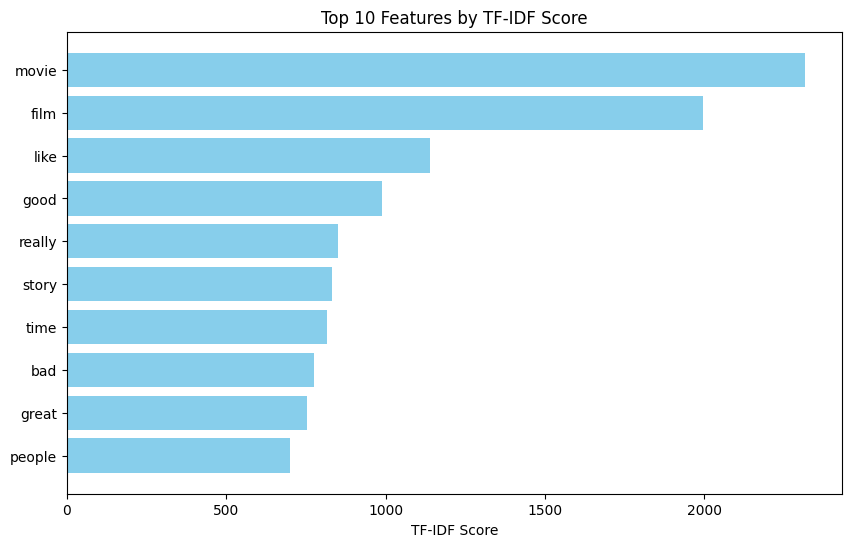

In [16]:
# Select top N features
top_n = 10
top_features = tfidf_scores.head(top_n)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features['Term'], top_features['TF-IDF Score'], color='skyblue')
plt.xlabel('TF-IDF Score')
plt.title(f'Top {top_n} Features by TF-IDF Score')
plt.gca().invert_yaxis()
plt.show()


# Step 5: Tokenize and Convert Text to Sequences

In [17]:
vocab_size = 5000  # Define the vocabulary size
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_text)

X_train_sequences = tokenizer.texts_to_sequences(X_train_text)
X_test_sequences = tokenizer.texts_to_sequences(X_test_text)

Sequence Type:  <class 'list'>
Size of X_train_sequences:  40000
Size of 1st element of X_train_sequences 191
Size of 2nd element of X_train_sequences 138
Max size:  1396
Min size:  3
Average size:  113.9109


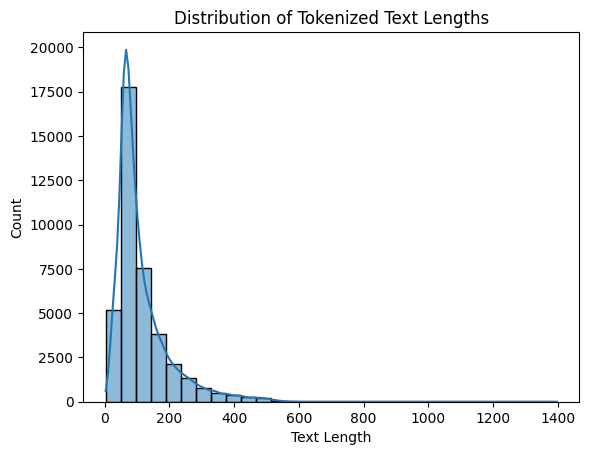

95th percentile length:  294


In [18]:
# Checking X after tokenize:

print('Sequence Type: ',type(X_train_sequences))
print('Size of X_train_sequences: ',len(X_train_sequences))
print('Size of 1st element of X_train_sequences',len(X_train_sequences[0]))
print('Size of 2nd element of X_train_sequences',len(X_train_sequences[1]))

sequence_sizes = [len(seq) for seq in X_train_sequences]
print('Max size: ', max(sequence_sizes))
print('Min size: ', min(sequence_sizes))
print('Average size: ', np.mean(sequence_sizes))

sns.histplot(sequence_sizes, kde=True, bins=30)
plt.title('Distribution of Tokenized Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

maxlen = int(np.percentile(sequence_sizes, 95))
print('95th percentile length: ', maxlen)

In [19]:
max_length = maxlen  # Define the maximum sequence length
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

In [20]:
print('Padded X type: ', type(X_train_padded))
print('Padded X shape: ', X_train_padded.shape)
print(X_train_padded[0])

Padded X type:  <class 'numpy.ndarray'>
Padded X shape:  (40000, 294)
[ 624 1899   32 1720 1787 4038    1  651 4763    1  124    1   21  729
   27   28   41  998 2102 1001  326  409  766  301    1   73 2868    1
 4133 2698  118   14   45 2986  139   99 4610    4   11    5    1   19
  240    3   99  182    1    1 1683    1   39  297    1    1 1484    1
  449  291  257   40   37  253    1    1  255    1 1851    1    1    1
  334  114  825 3927   78  540  481  128   35  670  112  298  250   10
 3592  160 1498   91    1    1  575 1673  995 2790    1 3454 1485    1
  120  103  203  901 2634    1    1 3729    2  852    1  384  134   17
   32   32  543    1    1 1151  125 4010    1  100  966 4011    1    1
 2095    1    1  312  495  564 2669 1098    1 3280   73 1281 1050 1394
  698 1061  189 2699  284  159 3241  816    1 1076  108    1  112    5
   94 1371  945 4522    1    1  122  232 3264    4   90    1 1608   61
   92   77   38  331  118  212 3253 1693    1 1171    3 3296 1855 2188
  334  

# Step 6: Neural Network Architecture

Neural network architecture
- How many layers? how many neurons each layer?
- Activation function to use? linear, relu, sigmoid
- Loss function (cost function to minimize): BinaryCrossentropy (sigmoid function)

**Layer 1:** Embedding layer transforms input sequences of word indices into dense vectors of fixed size, effectivelly capturing semantic relationships between words. Crucial for NLP networks.

In [21]:
embedding_dim = 100  # Define the embedding dimension

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dense(units=1, activation='sigmoid'))  # Adjust 'units' based on the number of sentiment classes

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [22]:
len(X_test_padded)

10000

In [23]:
epochs = 10
batch_size = 64

# Explicitly check if validation data is not None before passing it to model.fit
if X_test_padded is not None and y_test_encoded is not None:
    history = model.fit(
        X_train_padded,
        y_train_encoded,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_padded, y_test_encoded),
    )
else:
    print("Validation data is None. Skipping validation.")
    history = model.fit(
        X_train_padded,
        y_train_encoded,
        epochs=epochs,
        batch_size=batch_size,
    )


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 398s 632ms/step - accuracy: 0.5068 - loss: 0.6932 - val_accuracy: 0.5049 - val_loss: 0.6924
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 404s 646ms/step - accuracy: 0.5180 - loss: 0.6881 - val_accuracy: 0.5092 - val_loss: 0.6909
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 439s 642ms/step - accuracy: 0.5208 - loss: 0.6719 - val_accuracy: 0.5055 - val_loss: 0.6976
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 439s 636ms/step - accuracy: 0.5262 - loss: 0.6618 - val_accuracy: 0.5078 - val_loss: 0.7278
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 436s 627ms/step - accuracy: 0.5279 - loss: 0.6578 - val_accuracy: 0.5100 - val_loss: 0.7177
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 372s 596ms/step - accuracy: 0.6803 - loss: 0.5474 - val_accuracy: 0.8623 - val_loss: 0.3317
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 374s 583ms/step - accuracy: 0.9022 - loss: 0.2562 - val_accuracy: 0.8743 - val_loss: 0.3024
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 369s 563ms/step - accuracy: 0.9276 -

In [24]:
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print(f'Test Accuracy: {accuracy:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.8668 - loss: 0.3825
Test Accuracy: 0.8677


In [25]:
#model = Sequential()
#model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length))
#model.add(LSTM(units=100))
#model.add(Dense(1, activation='sigmoid'))

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])